In [6]:
from OSCC_postprocessing.playback.video_playback import *

# Importing libraries
from OSCC_postprocessing.analysis.multihole_utils import (
    preprocess_multihole,
    resolve_backend,
    rotate_segments_with_masks,
    compute_td_intensity_maps,
    estimate_peak_brightness_frames,
    # estimate_hydraulic_delay,
    compute_penetration_profiles,
    clean_penetration_profiles,
    binarize_plume_videos,
    compute_cone_angle_from_angular_density,
    estimate_offset_from_fft,
    triangle_binarize_gpu as _triangle_binarize_gpu,  # Backward compatibility
)

import time
import warnings

import matplotlib.pyplot as plt
import numpy as np

from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.binary_ops.functions_bw import bw_boundaries_single_plume
from OSCC_postprocessing.rotation.rotate_crop import generate_CropRect# , generate_plume_mask
from OSCC_postprocessing.analysis.multihole_utils import (
    preprocess_multihole,
    resolve_backend,
    rotate_segments_with_masks,
    compute_td_intensity_maps,
    estimate_peak_brightness_frames,
    # estimate_hydraulic_delay,
    compute_penetration_profiles,
    clean_penetration_profiles,
    binarize_plume_videos,
    compute_cone_angle_from_angular_density,
    estimate_offset_from_fft,
    triangle_binarize_gpu as _triangle_binarize_gpu,  # Backward compatibility
)

from OSCC_postprocessing.analysis.single_plume import (
    pre_processing_mie,
)

from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import (
    rotate_video_nozzle_at_0_half_numpy,
)
warnings.filterwarnings("ignore", category=RuntimeWarning)

global timing
timing = True

if timing:
    import time
import numpy as np
from OSCC_postprocessing.io.async_npz_saver import AsyncNPZSaver
from OSCC_postprocessing.io.async_avi_saver import *
from OSCC_postprocessing.filters.video_filters import *
from OSCC_postprocessing.playback.video_playback import *
from OSCC_postprocessing.analysis.single_plume import (
    USING_CUPY,
    cp,
    _min_max_scale,
    _rotate_align_video_cpu,
    binarize_single_plume_video,
    bw_boundaries_all_points_single_plume,
    bw_boundaries_xband_filter_single_plume,
    filter_schlieren,
    linear_regression_fixed_intercept,
    penetration_bw_to_index,
    pre_processing_mie,
    ransac_fixed_intercept,
    save_boundary_csv,
    to_numpy,
)
from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.binary_ops.binarized_metrics import processing_from_binarized_video
import pandas as pd

# Import rotation utility based on backend availability to avoid hard Cupy dependency
if USING_CUPY:
    from OSCC_postprocessing.rotation.rotate_with_alignment import (
        rotate_video_nozzle_at_0_half_cupy as rotate_video_nozzle_at_0_half_backend,
    )
else:
    from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import (
        rotate_video_nozzle_at_0_half_numpy as rotate_video_nozzle_at_0_half_backend,
    )

def _as_numpy(arr):
    if USING_CUPY and hasattr(arr, "__cuda_array_interface__"):
        return cp.asnumpy(arr)
    return np.asarray(arr)



In [7]:
from OSCC_postprocessing.cine.functions_videos import *
from pathlib import Path
import json
import os

file = Path(r"G:\Alberth\T121_Schlieren_4.cine")
json_file = Path(r"G:\Alberth\config.json")
out_dir = Path(r"G:\Alberth\Processed_Results")

# Video is in uint12 
video_bits = 12
brightness_levels = 2.0**video_bits

# Load the .cine file into a 3D numpy array (gray scale, shape: (Frame, Height, Width))
video = load_cine_video(file)

# Normalize the grayscale video to [0, 1] brightness range
video = video / brightness_levels

F, H, W = video.shape

with open(json_file, 'r', encoding='utf-8') as f:
    # Load metadata
    data = json.load(f)
    number_of_plumes = int(data['plumes'])
    offset = float(data['offset']) # Not used in multi hole (Calculated later by FFT)
    centre = (float(data['centre_x']), float(data['centre_y']))
    ir_ = float(data["inner_radius"])   # inner radius (Injector radius)
    or_ = float(data["outer_radius"])   # outer radius (Quatz window radius)

print(f"The injector has {number_of_plumes} plumes.")
print(f"The nozzle is centred at ({centre[0]:.2f}, {centre[1]:.2f}) in image coordinates.")

Video Info - Width: 768, Height: 768, Frames: 401
The injector has 1 plumes.
The nozzle is centred at (206.00, 98.00) in image coordinates.


In [4]:
play_video_cv2(video, intv=17)

([], [])

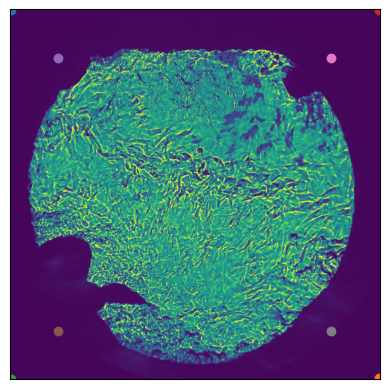

In [17]:
pts = [[2, 1],
       [766, 766], 
       [1, 767], 
       [767, 1],
       [100, 100],
       [100, 667],
       [667, 100],
       [667, 667]]

plt.imshow(_as_numpy(video[0]))
for pt in pts:
       plt.scatter(pt[0], pt[1])

plt.xticks([])
plt.yticks([])

Text(0.5, 0, 'sampled intensity')

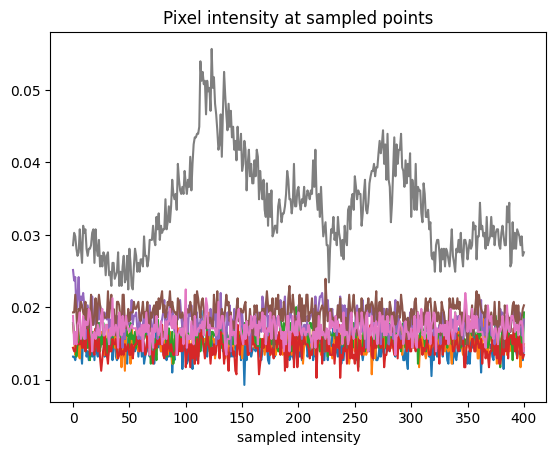

In [20]:
signals = np.zeros((len(pts), F))

for i, pt in enumerate(pts):
    signals[i] = _as_numpy(video[:, pt[0], pt[1]])

plt.plot(signals.T)
plt.title("Pixel intensity at sampled points")
plt.xlabel("sampled intensity")

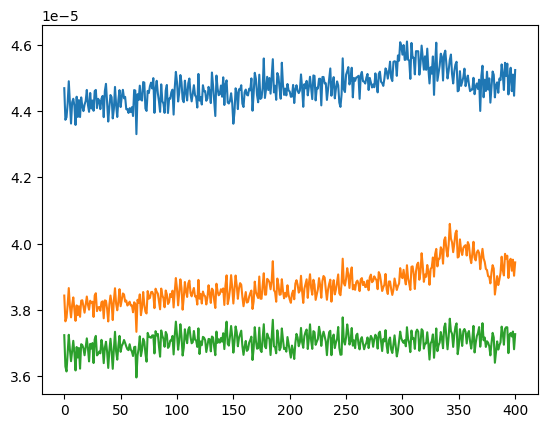

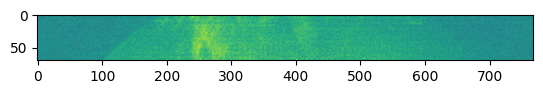

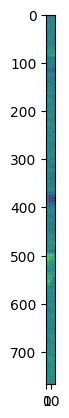

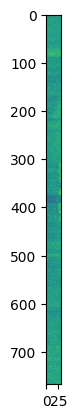

In [37]:
patch1 = video[:, :70, :]
patch2 = video[:, :, 750:]
patch3 = video[:, 740:, :]
patch4 = video[:, :, :30]
plt.plot(_as_numpy(cp.sum(patch1, axis=(1,2))/(patch1.shape[0]*patch1.shape[1]*patch1.shape[2])))
plt.plot(_as_numpy(cp.sum(patch2, axis=(1,2))/(patch2.shape[0]*patch2.shape[1]*patch2.shape[2])))
# plt.plot(_as_numpy(cp.sum(patch3, axis=(1,2))/(patch3.shape[0]*patch3.shape[1]*patch3.shape[2])))
plt.plot(_as_numpy(cp.sum(patch4, axis=(1,2))/(patch4.shape[0]*patch4.shape[1]*patch4.shape[2])))


plt.show()
plt.imshow(_as_numpy(patch1[0]))
plt.show()
plt.imshow(_as_numpy(patch2[0]))
plt.show()
# plt.imshow(_as_numpy(patch3[0]))
plt.show()
plt.imshow(_as_numpy(patch4[0]))

In [38]:
# Check the hardware used for image processing

use_gpu, triangle_backend, xp = resolve_backend(use_gpu="auto", triangle_backend="auto")

print("CUDA is used:", use_gpu)

print("xp represents numpy or cupy? :",xp)

CUDA is used: True
xp represents numpy or cupy? : <module 'cupy' from 'c:\\Users\\Jiang\\Documents\\Mie_Py\\Mie_Postprocessing_Py\\.venv311\\Lib\\site-packages\\cupy\\__init__.py'>


(206.0, 98.0)

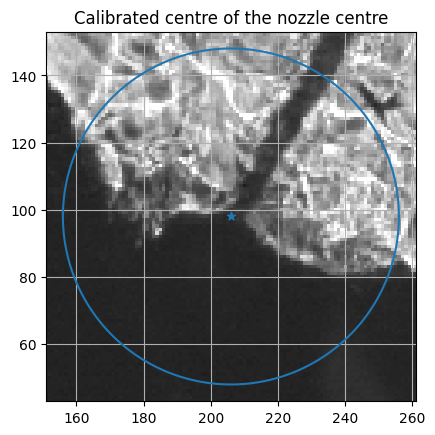

In [40]:
r = 50

# Displaying the clibration
plt.imshow(video[100]**0.5, cmap="gray")
plt.scatter(centre[0], centre[1], marker="*")

theta = np.linspace(0, 2*np.pi, 400)

x0, y0 = centre[0] , centre[1]

x = x0 + r * np.cos(theta)
y = y0 + r * np.sin(theta)

plt.plot(x, y, linewidth="1.5")
# plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
# plt.show()

plt.xlim([max(0, centre[0]-1.1*r), min(W, centre[0]+1.1*r)])
plt.ylim([max(0, centre[1]-1.1*r), min(H, centre[1]+1.1*r)])
plt.title("Calibrated centre of the nozzle centre")
centre



In [48]:
# Rotation


# Frames, Height, Width
F, H, W = video.shape

# Image rotation settings
INTERPOLATION = "nearest"
BORDER_MODE = "constant"

# Arbitrary rotated image strip shape
OUT_SHAPE = (H, H)

video = cp.asarray(video)

segment, _, _ = rotate_video_nozzle_at_0_half_backend(
        video,
        centre, # (nozzle_x, nozzle_y) # change to centre_x + cos(angle) * r, centre_y + sin(angle) * r
        # (centre[0] + np.cos(angle/180.0*np.pi) * ir_, centre[1] + np.sin(angle/180.0*np.pi) * ir_),
        offset,
        interpolation=INTERPOLATION,
        border_mode=BORDER_MODE,
        out_shape=OUT_SHAPE,
    )

segment = cp.asarray(_min_max_scale(segment))

In [44]:
play_video_cv2(segment.get(), intv=17)

In [51]:
rotated_patch1 = segment[:, :250, :]

rotated_patch2 = segment[:, 550:, :]


In [ ]:
play_video_cv2(_as_numpy(rotated_patch1), intv=17)


In [55]:
play_video_cv2(_as_numpy(rotated_patch2), intv=17)

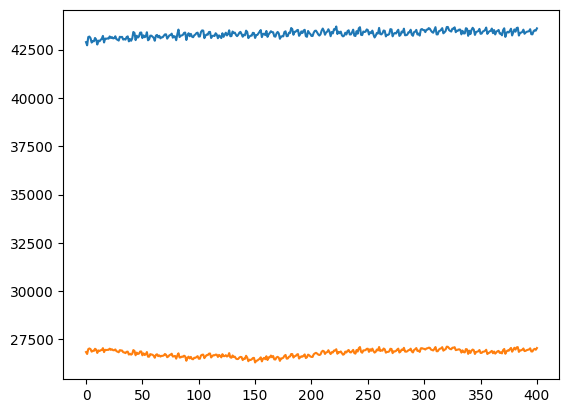

In [54]:
plt.plot(_as_numpy(xp.sum(rotated_patch1, axis=(1,2))))
plt.plot(_as_numpy(xp.sum(rotated_patch2, axis=(1,2))))

In [ ]:
td_map = xp.sum(segment, axis=1).T

Text(0, 0.5, 'pixels')

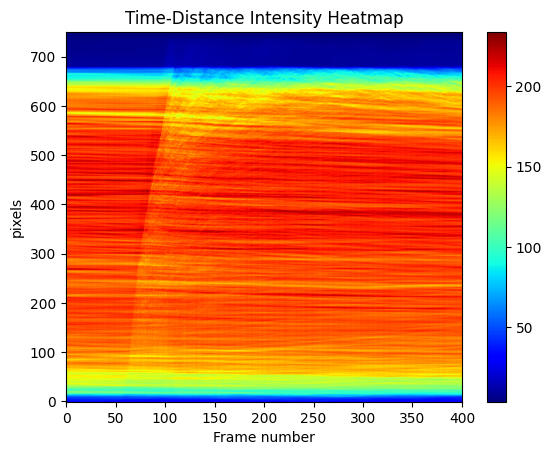

In [ ]:
plt.imshow(td_map.get(), origin="lower", aspect="auto", cmap="jet")
plt.title("Time-Distance Intensity Heatmap")
plt.colorbar()
plt.xlabel("Frame number")
plt.ylabel("pixels")

Text(0, 0.5, 'pixels')

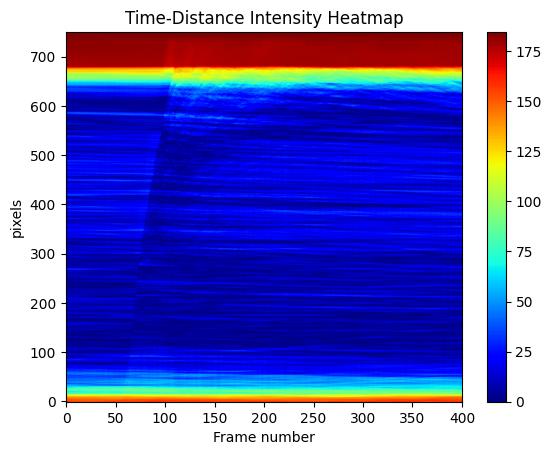

In [ ]:
plt.imshow(np.abs(td_map.get() - np.median(td_map.get())), origin="lower", aspect="auto", cmap="jet")
plt.title("Time-Distance Intensity Heatmap")
plt.colorbar()
plt.xlabel("Frame number")
plt.ylabel("pixels")

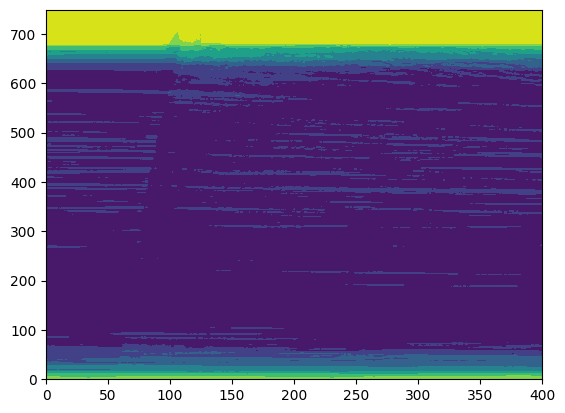

In [ ]:
plt.contourf(np.abs(td_map.get() - np.median(td_map.get())))

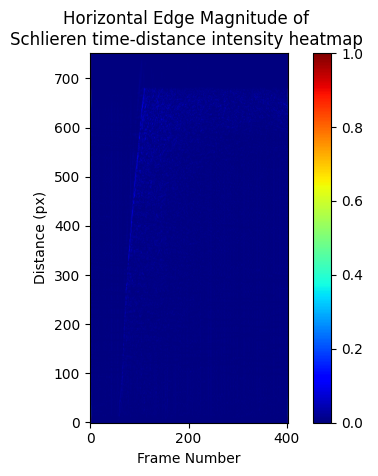

In [ ]:
map = np.abs(td_map.get() - np.median(td_map.get()))


import scipy
kernel = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
])
edge_magnitude_horizontal = scipy.signal.convolve2d(map, kernel)

# edge_magnitude_vertical = scipy.signal.convolve2d(map, kernel.T)
normalized_magnitude_map = _min_max_scale(np.abs(edge_magnitude_horizontal))

plt.imshow(normalized_magnitude_map, origin="lower", cmap="jet")
plt.title("Horizontal Edge Magnitude of \nSchlieren time-distance intensity heatmap ")

plt.xlabel("Frame Number")
plt.ylabel("Distance (px)")

plt.colorbar()

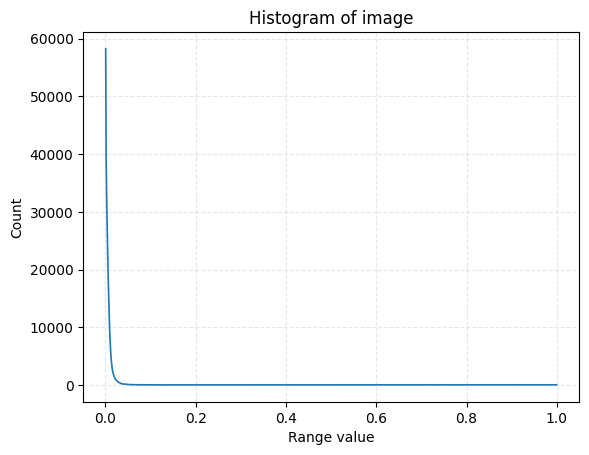

In [ ]:
imhist(_min_max_scale(np.abs(edge_magnitude_horizontal)))

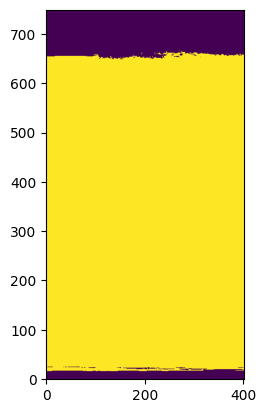

In [ ]:
from OSCC_postprocessing.analysis.single_plume import *
from OSCC_postprocessing.binary_ops.functions_bw import *
 


bw = _min_max_scale(td_map) > 0.41 # triangle_binarize_gpu(_min_max_scale(td_map))

plt.imshow(bw.get(), origin="lower")
                

In [ ]:
def to_numpy(arr):
    return cp.asnumpy(arr) if USING_CUPY else np.asarray(arr)

In [ ]:
from OSCC_postprocessing.io import * 
from pathlib import Path
npz_saver = AsyncNPZSaver(max_workers=2)
avi_saver = AsyncAVISaver(max_workers=2)

save_name_stem = Path(file).stem

Path(out_dir/"Rotated_Videos").mkdir(parents= True, exist_ok=True)
Path(out_dir / "Postprocessed_Data").mkdir(parents=True, exist_ok=True)

save_path_video = out_dir / "Rotated_Videos"
save_path_data = out_dir / "Postprocessed_Data"

# Save the Foreground video asynchronously
avi_saver.save(save_path_video / (save_name_stem + ".avi"), to_numpy(segment), is_color=False)
               
npz_saver.save(save_path_video / (save_name_stem + ".npz"), segment=to_numpy(segment))


<Future at 0x197214fdcd0 state=running>

In [ ]:
from OSCC_postprocessing.filters.svd_background_removal import * 

svd_segment = svd_foreground_cuda(segment, rank=100, bkg_frame_limit=40)

svd_positive = svd_segment.copy()
svd_positive[svd_positive < 0] = 0

scaled_svd_segment = _min_max_scale(-svd_positive)*10.0



In [ ]:
play_video_cv2(scaled_svd_segment.get(), intv=17)



Text(0, 0.5, 'pixels')

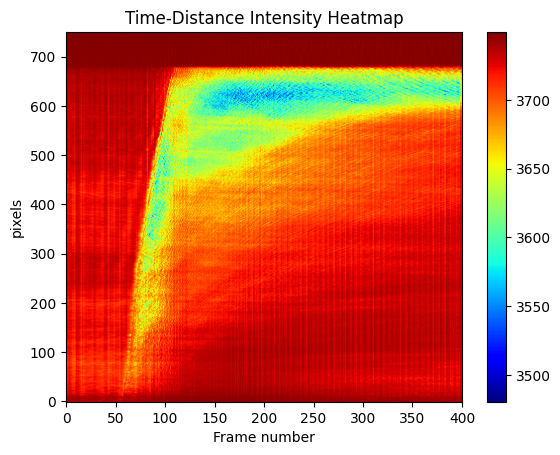

In [ ]:
td_map = xp.sum(scaled_svd_segment, axis=1).T
plt.imshow(td_map.get(), origin="lower", aspect="auto", cmap="jet")
plt.title("Time-Distance Intensity Heatmap")
plt.colorbar()
plt.xlabel("Frame number")
plt.ylabel("pixels")

In [ ]:
cat_vids = np.concatenate([to_numpy(segment), to_numpy(np.clip(5.0*svd_segment, 0, 1))], axis=1)

play_video_cv2(cat_vids, intv=17)

In [ ]:
avi_saver.save(save_path_video / (save_name_stem + "_svd_foreground.avi"), to_numpy(cat_vids), is_color=False)

<Future at 0x19b4887c440 state=pending>